In [1]:
!python --version

Python 3.10.11


In [ ]:
!pip install tensorflow, seaborn, scikit-learn, pandas

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2, MobileNetV3Small, Xception, VGG16, VGG19, ResNet50V2, InceptionV3, InceptionResNetV2, DenseNet121, NASNetMobile
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2, l1, l1_l2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.utils import plot_model
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
print(tf.__version__)

2.16.1


In [5]:
def show_one_image_per_class(data_dir, classes, img_size=(224, 224)):
    fig, axes = plt.subplots(1, len(classes), figsize=(20, 20))
    for ax, class_name in zip(axes, classes):
        class_dir = os.path.join(data_dir, class_name)
        img_name = os.listdir(class_dir)[0]  # Get the first image in the directory
        img_path = os.path.join(class_dir, img_name)

        # Load and preprocess the image
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0

        # Display the image
        ax.imshow(img_array)
        ax.set_title(class_name)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [6]:
train_dir = 'augmented_focus/train/'
val_dir = 'augmented_focus/val/'
test_dir = 'augmented_focus/test/'

classes = ['clean', 'dusty', 'bird_drop', 'electrical_damage', 'physical_damage']

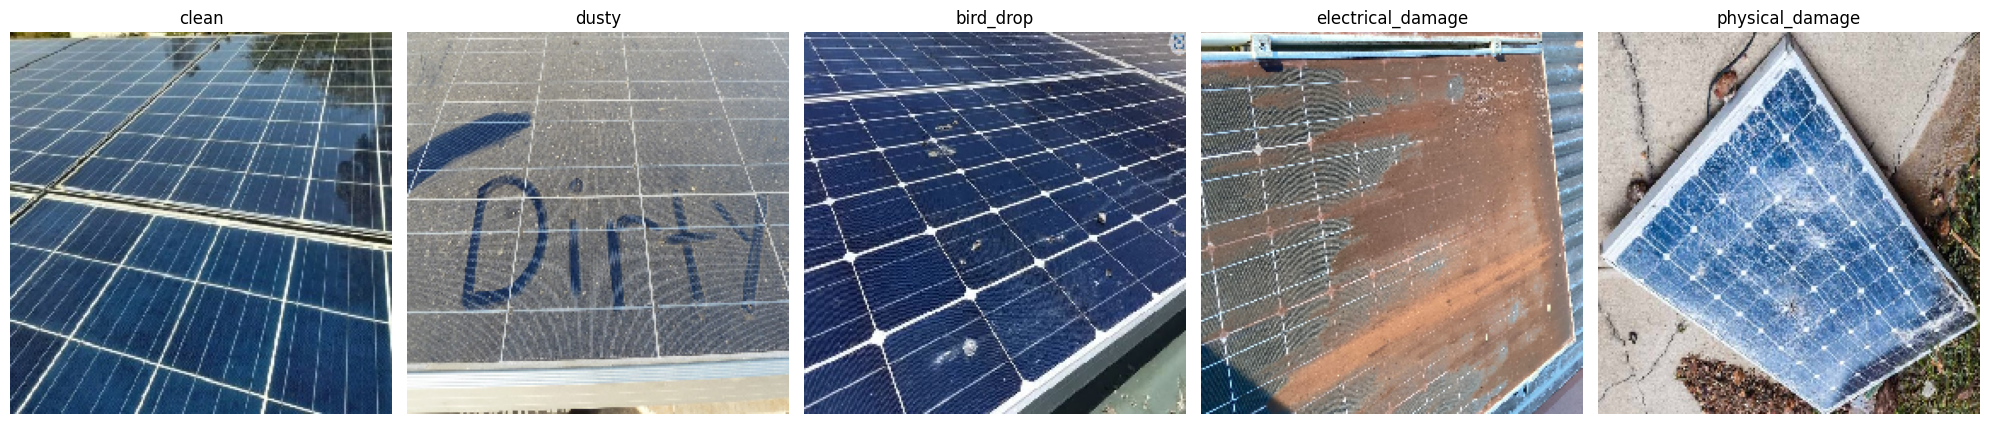

In [7]:
show_one_image_per_class(train_dir, classes)

In [8]:
# data augmentation for training and normalization
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
)
val_datagen = ImageDataGenerator(rescale=1.0/255.0,)
test_datagen = ImageDataGenerator(rescale=1.0/255.0,)

# generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), 
    batch_size=64,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,      
    target_size=(224, 224), 
    batch_size=64,
    class_mode='categorical',
    shuffle=False           
)

Found 814 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Found 106 images belonging to 5 classes.


In [9]:
# list of models used
models = [
    MobileNetV2
]

In [10]:
# Directory to save the best models
save_dir = 'saved_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Directory to save the model summaries
model_summary_dir = 'model_summaries'
if not os.path.exists(model_summary_dir):
    os.makedirs(model_summary_dir)

# Directory to save the model architecture plots
plot_dir = 'model_architecture_plots'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# Directory to save accuracy and loss plots
plots_dir = 'plots'
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

# Directory to save the training history CSV files
history_dir = 'training_histories'
if not os.path.exists(history_dir):
    os.makedirs(history_dir)

# Directory to save the confusion matrices
confusion_matrix_dir = 'confusion_matrices'
if not os.path.exists(confusion_matrix_dir):
    os.makedirs(confusion_matrix_dir)

# Directory to save the classification reports
classification_report_dir = 'classification_reports'
if not os.path.exists(classification_report_dir):
    os.makedirs(classification_report_dir)

# Dictionary to store the training histories
histories = {}

In [19]:
# Create, modify, compile, and add callbacks to each model
for model in models:
    base_model = model(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    
    # Create the Sequential model and add layers
    keras_model = Sequential()
    keras_model.add(base_model)  
    keras_model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
    keras_model.add(layers.Dropout(0.5))
    keras_model.add(layers.GlobalAveragePooling2D())
    keras_model.add(layers.Dropout(0.5))
    keras_model.add(layers.Dense(5, activation='softmax', kernel_regularizer=l2(0.0001)))
    
    # Compile the new model
    keras_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Create callbacks for this model
    model_name = model.__name__
    
    summary_file = os.path.join(model_summary_dir, f'{model_name}_summary.txt')
    with open(summary_file, 'w', encoding='utf-8') as f:
        keras_model.summary(print_fn=lambda x: f.write(x + '\n'))
    
    
    model_checkpoint = ModelCheckpoint(
        filepath=os.path.join(save_dir, f'best_model_{model_name}.keras'),
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    )
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        mode='min',
        verbose=1,
        restore_best_weights=True
    )
    
    model_callbacks = [model_checkpoint, early_stopping]

    # Train the model
    history = keras_model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=20,
        callbacks=model_callbacks
    )

    # Save the training history
    histories[model_name] = history.history
    
    # Save the history to CSV
    history_df = pd.DataFrame(history.history)
    history_csv_file = os.path.join(history_dir, f'{model_name}_history.csv')
    history_df.to_csv(history_csv_file, index=False)
    
    print("-" * 30)
    
    # Plot the model architecture and save as an image file
    plot_file = os.path.join(plot_dir, f'{model_name}.png')
    plot_model(keras_model, to_file=plot_file, show_shapes=True, show_layer_names=True)

    # Generate confusion matrix
    y_pred = np.argmax(keras_model.predict(test_generator), axis=-1)
    y_true = test_generator.labels
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    cm_file = os.path.join(confusion_matrix_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_file)
    plt.close()

    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=classes)
    report_file = os.path.join(classification_report_dir, f'{model_name}_classification_report.txt')
    with open(report_file, 'w', encoding='utf-8') as f:
        f.write(report)

    # Plot accuracy and loss
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()


    metrics = ['accuracy', 'loss']
    for i, metric in enumerate(metrics):
        plt.subplot(1, 2, i+1)
        plt.plot(history.history[metric], label=f'Training {metric.capitalize()}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}')
        plt.title(f'{metric.capitalize()}')
        plt.xlabel('Epochs')
        plt.ylabel(f'{metric.capitalize()}')
        plt.legend()
    
    plt.tight_layout() 
    plt.show()

    
    # Save the plot
    plot_acc_loss_file = os.path.join(plots_dir, f'{model_name}_accuracy_loss.png')
    plt.savefig(plot_acc_loss_file)
    plt.close()

print(f"TensorFlow Keras models have been saved in the directory: {save_dir}")
print(f"Training histories have been saved in the directory: {history_dir}")
print(f"Model architectures have been saved in the directory: {plot_dir}")
print(f"Confusion matrices have been saved in the directory: {confusion_matrix_dir}")
print(f"Classification reports have been saved in the directory: {classification_report_dir}")
print(f"Model summaries have been saved in the directory: {model_summary_dir}")
print(f"Accuracy and loss plots have been saved in the directory: {plots_dir}")

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2637 - loss: 2.1366
Epoch 1: val_loss improved from inf to 1.05315, saving model to saved_models\best_model_MobileNetV2.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.2687 - loss: 2.1097 - val_accuracy: 0.6700 - val_loss: 1.0531
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5275 - loss: 1.1738
Epoch 2: val_loss improved from 1.05315 to 0.84753, saving model to saved_models\best_model_MobileNetV2.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.5308 - loss: 1.1696 - val_accuracy: 0.7600 - val_loss: 0.8475
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6272 - loss: 0.9936
Epoch 3: val_loss improved from 0.84753 to 0.66452, saving model to saved_models\best_model_MobileNetV2.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.6290 - loss: 0.9896 - val_accuracy: 0.8300 - val_loss: 0.6645
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7016 - loss: 0.83

##### 